## 2.3 Two Simple Approaches to Prediction: Least Squares and Nearest Neighbors

In [6]:
library(dplyr)
library(ggplot2)
library(ggthemes)
library(class)
library(MASS)
options(repr.plot.width=6, repr.plot.height=4)
set.seed(1234)

generate_data <- function(n.means=10, n.obs.per.class=100) {    
    blue.means <- mvrnorm(n=n.means, mu=c(0, 1), Sigma=diag(2))
    orange.means <- mvrnorm(n=n.means, mu=c(1, 0), Sigma=diag(2))
    blue.data <- t(sapply(sample(1:n.means, n.obs.per.class, replace=TRUE),
                          function(x) {mvrnorm(n=1, mu=blue.means[x,], Sigma=diag(2)/5)}))
    orange.data <- t(sapply(sample(1:n.means, n.obs.per.class, replace=TRUE),
                            function(x) {mvrnorm(n=1, mu=orange.means[x,], Sigma=diag(2)/5)}))
    return(data.frame(x=c(blue.data[, 1], orange.data[, 1]),
                      y=c(blue.data[, 2], orange.data[, 2]),
                      class=c(rep('BLUE', n.obs.per.class), rep('ORANGE', n.obs.per.class))))
}

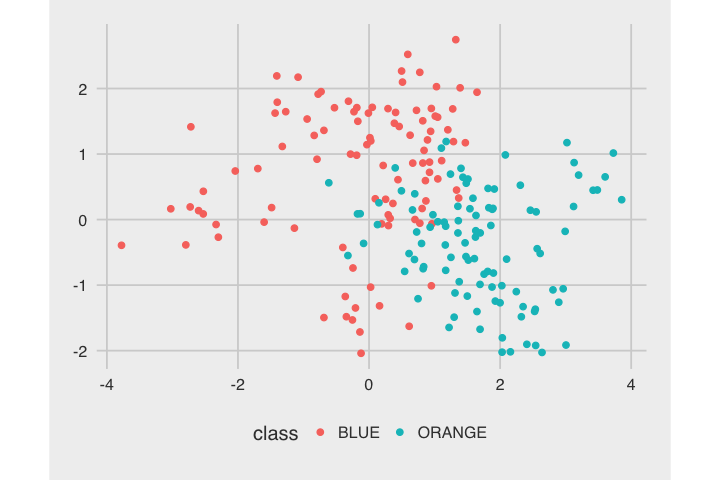

In [7]:
df <- generate_data(n.means=10, n.obs.per.class=100)
plot.df <- function() {
    g <- ggplot() +
            geom_point(data=df, aes(x=x, y=y, color=class)) +
            coord_fixed() +
            theme_fivethirtyeight()
    return(g)
}

plot.df()

## Least Squares

Let's try finding the decision boundary for the least squares linear fit. We could find the linear fit using the `lm` function, but let's try building it from scratch.

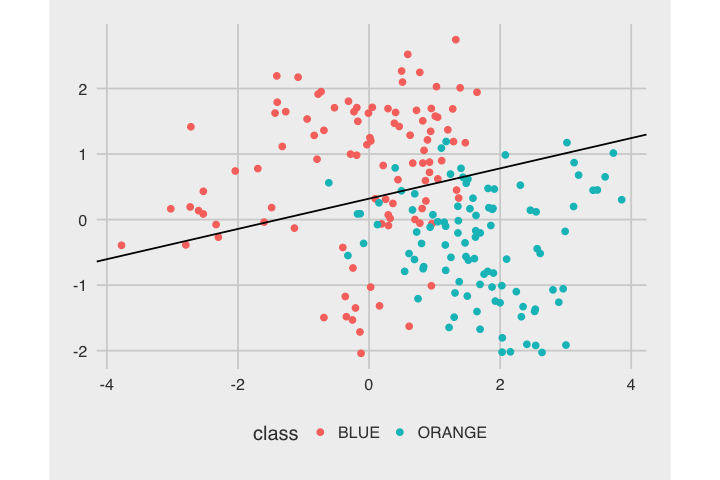

In [8]:
X <- df %>% dplyr::select(-c(y, class)) %>%
            mutate(intercept = 1) %>%
            as.matrix()
y <- as.matrix(as.numeric(df$class == 'ORANGE'), nrow(df), 1)

# Use the normal equation to compute the coefficients
betas <- solve(t(X) %*% X) %*% t(X) %*% y
betas <- as.data.frame(t(betas))

plot.df() +
    geom_abline(slope=betas$x, intercept=betas$intercept)

## kNN

Below are functions to train and predict a kNN model with various levels of k. By default the function will output predictions for a grid of the input space, so that a decision boundary can be produced. Otherwise, an optional test set can be provided.

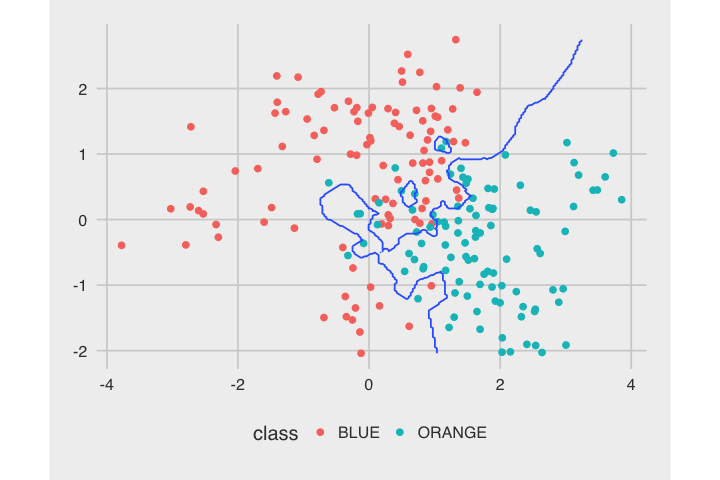

In [9]:
pred_knn <- function(data, k=10, test.data=NULL) {
    if (is.null(test.data)) {
        xs <- seq(min(data$x), max(data$x), length.out=250)
        ys <- seq(min(data$y), max(data$y), length.out=250)
        test.data <- expand.grid(x=xs, y=ys)
    }
    
    pred <- knn(train=as.matrix(dplyr::select(data, -class)),
                test=as.matrix(test.data),
                cl=data$class,
                k=k, prob=TRUE)
    p <- data.frame(preds = as.character(pred),
                    probs = attr(pred, 'prob')) %>%
            mutate(prob.blue = (probs * (preds == 'BLUE')) + ((1 - probs) * (preds == 'ORANGE')))
    return(cbind(test.data, p))
}

p <- pred_knn(df, k=2)

plot.df() +
    geom_contour(data=p, aes(x=x, y=y, z=prob.blue), breaks=c(0., .5))

Below shows the prediction errors on a test set for various k values in a kNN model.

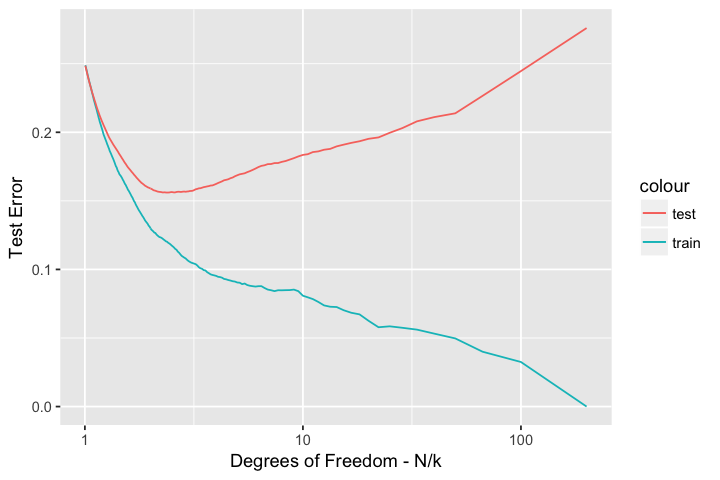

In [10]:
test.data <- generate_data(n.means=10, n.obs.per.class=1000)

pred_obs <- function(data, k=5, test.data=NULL) {
    p <- pred_knn(data, k=k, test.data=dplyr::select(test.data, -class)) %>%
            dplyr::select(-c(preds, probs, x, y)) %>%
            cbind(test.data) %>%
            mutate(observed.blue = as.numeric(class == 'BLUE')) %>%
            dplyr::select(-c(x, y, class)) %>%
            dplyr::select(pred = prob.blue, obs = observed.blue)
    return(mean((p$pred - p$obs) ** 2))
}

errs <- NULL
for (k in seq(nrow(df) - 1)) {
    train.err <- pred_obs(df, k=k, test.data=df)
    test.err <- pred_obs(df, k=k, test.data=test.data)
    errs <- rbind(errs, data.frame(dof=(nrow(df)/k), train=train.err, test=test.err))
}

ggplot(errs, aes(x=dof)) +
    geom_line(aes(y=train, color='train')) +
    geom_line(aes(y=test, color='test')) +
    scale_x_log10() +
    xlab('Degrees of Freedom - N/k') +
    ylab('Test Error')

## Local Methods in High Dimensions

The following is a recreation of Figure 2.7

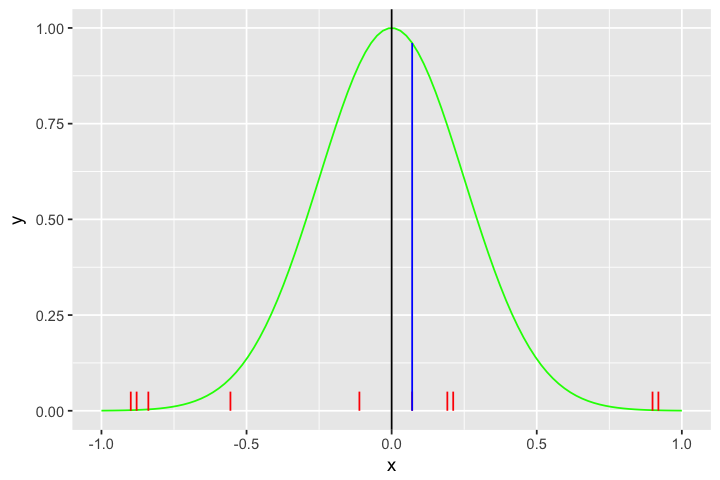

In [11]:
x <- seq(-1, 1, length.out=100)
d <- data.frame(x=x, y=exp(-8 * (x ** 2))) %>%
        mutate(dist=abs(x))
small.samp <- d[sample(nrow(d), 10), ]
ggplot(d, aes(x=x, y=y)) +
    geom_line(color='green') +
    geom_vline(xintercept=0, color='black') +
    geom_segment(data=small.samp,
                 mapping=aes(x=x, y=0, xend=x, yend=0.05),
                 color='red') +
    geom_segment(data=dplyr::filter(small.samp, dist == min(dist)),
                 mapping=aes(x=x, y=0, xend=x, yend=y), color='blue')

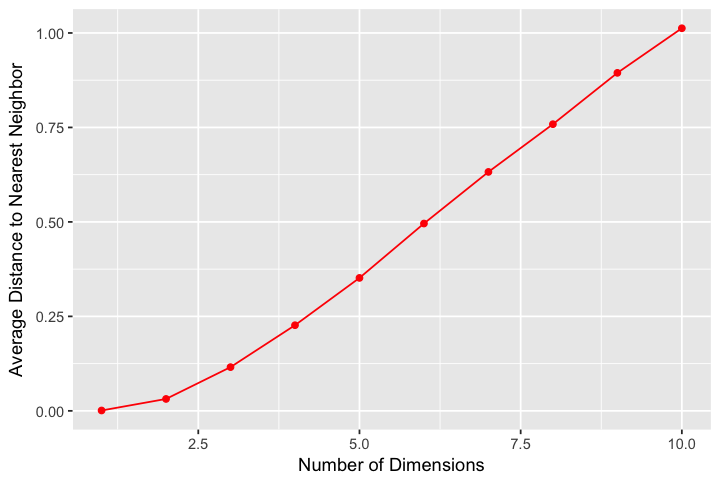

In [12]:
mvunif <- function(n=100, p=3) {
    vals <- NULL
    for (i in seq(p)) {
        vals <- cbind(vals, runif(n=n, min=-1, max=1))
    }
    return(vals)
}

radius_of_closest <- function(df) {
    dists <- as.matrix(dist(df))
    diag(dists) <- NA
    return(apply(dists, 1, min, na.rm=TRUE))
}

neighbor.dists <- data.frame(k=seq(10),
                             r=sapply(seq(10), function(x) {
                                 d <- mvunif(n=1000, p=x); mean(radius_of_closest(d))
                             }))

ggplot(neighbor.dists, aes(x=k, y=r)) +
    geom_point(color='red') + geom_line(color='red') +
    xlab('Number of Dimensions') +
    ylab('Average Distance to Nearest Neighbor')

In [13]:
estimate_f0 <- function(n=1000, p=3, equation) {
    # Create the problem as stated
    x <- as.matrix(mvunif(n=n, p=p))
    y <- equation(x)
    #y <- exp(-8 * apply(x, 1, norm, '2'))
    df2 <- data.frame(x=x, y=y)
    
    # Find the observation with the smallest norm, this is the observation
    # that is the closest neighbor to the origin
    closest <- data.frame(norm=apply(dplyr::select(df2, -y), 1, norm, '2'), y=df2$y) %>%
                filter(norm == min(norm))
    return(closest$y)
}

compute_mse <- function(n=1000, p=3, f0=1, equation) {
    print(paste0('Running MSE with n=', n, ' and p=', p))
    yhat_0 <- sapply(seq(100), function(x) { estimate_f0(n=n, p=p, equation=equation) })
    return(data.frame(mse=var(yhat_0) + ((mean(yhat_0) - f0) ** 2),
                      bias=(mean(yhat_0) - 1) ** 2,
                      variance=var(yhat_0)))
}

[1] "Running MSE with n=1000 and p=1"
[1] "Running MSE with n=1000 and p=2"
[1] "Running MSE with n=1000 and p=3"
[1] "Running MSE with n=1000 and p=4"
[1] "Running MSE with n=1000 and p=5"
[1] "Running MSE with n=1000 and p=6"
[1] "Running MSE with n=1000 and p=7"
[1] "Running MSE with n=1000 and p=8"
[1] "Running MSE with n=1000 and p=9"
[1] "Running MSE with n=1000 and p=10"


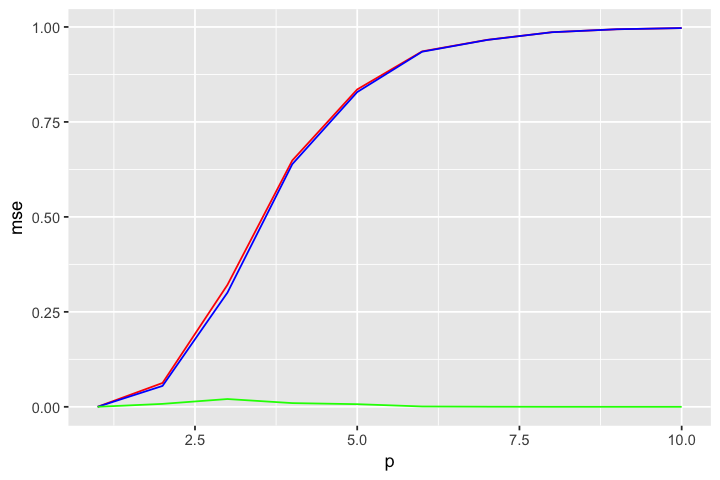

In [14]:
exp.eq <- function(x) exp(-8 * apply(x, 1, norm, '2'))
bias.variance <- t(sapply(seq(10), function(x) { compute_mse(n=1000, p=x, equation=exp.eq, f0=1) }))
df3 <- data.frame(mse=as.numeric(bias.variance[, 'mse']),
                  bias_sq=as.numeric(bias.variance[, 'bias']),
                  variance=as.numeric(bias.variance[, 'variance']),
                  p=seq(10))

ggplot(df3, aes(x=p)) +
    geom_line(aes(y=mse), color='red') +
    geom_line(aes(y=bias_sq), color='blue') +
    geom_line(aes(y=variance), color='green')

The following is a recreation of Figure 2.8

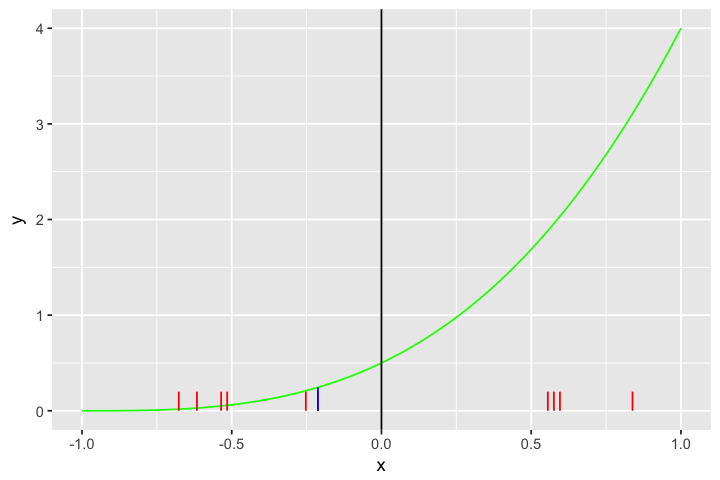

In [15]:
x <- seq(-1, 1, length.out=100)
d <- data.frame(x=x, y=0.5 * ((x + 1) ** 3)) %>%
        mutate(dist=abs(x))
small.samp <- d[sample(nrow(d), 10), ]
ggplot(d, aes(x=x, y=y)) +
    geom_line(color='green') +
    geom_vline(xintercept=0, color='black') +
    geom_segment(data=small.samp,
                 mapping=aes(x=x, y=0, xend=x, yend=0.2),
                 color='red') +
    geom_segment(data=dplyr::filter(small.samp, dist == min(dist)),
                 mapping=aes(x=x, y=0, xend=x, yend=y), color='blue')

[1] "Running MSE with n=1000 and p=1"
[1] "Running MSE with n=1000 and p=2"
[1] "Running MSE with n=1000 and p=3"
[1] "Running MSE with n=1000 and p=4"
[1] "Running MSE with n=1000 and p=5"
[1] "Running MSE with n=1000 and p=6"
[1] "Running MSE with n=1000 and p=7"
[1] "Running MSE with n=1000 and p=8"
[1] "Running MSE with n=1000 and p=9"
[1] "Running MSE with n=1000 and p=10"


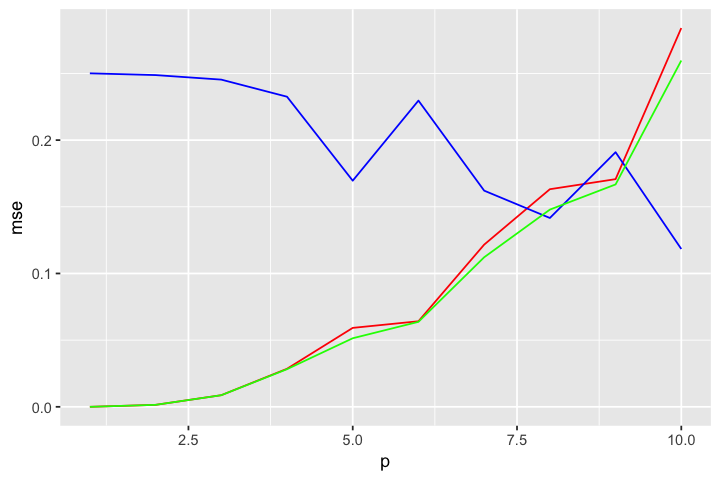

In [17]:
exp.eq <- function(x) 0.5 * ((x[, 1] + 1) ** 3)
bias.variance <- t(sapply(seq(10), function(x) { compute_mse(n=1000, p=x, equation=exp.eq, f0=0.5) }))
df3 <- data.frame(mse=as.numeric(bias.variance[, 'mse']),
                  bias_sq=as.numeric(bias.variance[, 'bias']),
                  variance=as.numeric(bias.variance[, 'variance']),
                  p=seq(10))

ggplot(df3, aes(x=p)) +
    geom_line(aes(y=mse), color='red') +
    geom_line(aes(y=bias_sq), color='blue') +
    geom_line(aes(y=variance), color='green')